In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [0]:

import dataclasses
import numpy as np
from scipy.integrate import odeint
import whynot as wn
from whynot.dynamics import BaseConfig , BaseState , BaseIntervention
import torch
import torch.nn as nn
import torch.optim as optim
from whynot.gym import spaces
from whynot.gym.envs import ODEEnvBuilder, register
import whynot.gym as gym
import pandas as pd
import matplotlib.pyplot as plt

Simulator
Including : 

1.   Config
2.   State
3.   Intervention
4.   Dyanmic / simulate



In [0]:
#Agegroups and fatality probability reel data
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))
agegroups = agegroup_lookup["Morocco"]
# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)
prob_I_to_C = np.mean([np.mean(prob_I_to_C_1),np.mean(prob_I_to_C_2)])
prob_C_to_D = np.mean([np.mean(prob_C_to_Death_1),np.mean(prob_C_to_Death_2)])
beds_per_100k = 110

In [0]:

#Using dataclasses makes attribute manipulation easier
@dataclasses.dataclass
class Config(BaseConfig):
    #attr_name: type = value
    #Model simulator hyperparameters
    gamma: float = 1.0/9.0
    sigma: float = 1.0/3.0
    days_nbr: int = 100
    Rate: float = 0
    eco_rate: float = 0
    R : float = 5.0
    #Scale factor of beds number
    s: float = 0.01
    beds : int = beds_per_100k / 100_000 * sum(agegroups) 
    p_I_to_C : float = prob_I_to_C
    p_C_to_D : float = prob_C_to_D
    #: Simulation start time (in day)
    start_time: float = 0
    #: Simulation end time (in days)
    end_time: float = 400
#Defining state class and initiating With 1 infected case
@dataclasses.dataclass
class State(BaseState):
    #Number of susceptible
    susceptible: int = sum(agegroups)
    #Number of exposed
    exposed: int = 1 
    #Number of infected
    infected: int =1
    #Number of critical cases
    critical: int = 0
    #Number of recovered cases
    recovered: int = 0
    #Number of death cases
    deaths: int =0
    economy: int = 100000000

class Intervention(BaseIntervention):
    def __init__(self , time, **kwargs):
        #Specifiying an intervention in the dynamical system
        #Making a decision at time step X 
        super(Intervention, self).__init__(Config, time, **kwargs)
def dynamics(y, time, config,intervention= None):
    R = 5.0
    N = sum(agegroups)
    S, E, I, C, R, D,EC  = y
    #In case of intervention
    if intervention and time >= intervention.time:
      config = config.update(intervention)
      config.R -= config.R * config.Rate
    beta = config.R * config.gamma 
    dSdt = -beta * I * S / N
    dEdt = beta * I * S / N - config.sigma * E
    dIdt = config.sigma * E - 1/12.0 * config.p_I_to_C * I - config.gamma * (1 - config.p_I_to_C) * I
    dCdt = 1/12.0 * config.p_I_to_C * I - 1/7.5 * config.p_C_to_D * min((config.beds), C) - max(0, C-(config.beds)) - (1 - config.p_C_to_D) * 1/6.5 * min((config.beds), C)
    dRdt = config.gamma * (1 - config.p_I_to_C) * I + (1 - config.p_C_to_D) * 1/6.5 * min(config.beds, C)
    dDdt = 1/7.5 * config.p_C_to_D * min((config.beds), C) + max(0, C-(config.beds))
    EC = - config.eco_rate * 100
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt,EC
def simulate( initial_state,config , intervention=None,seed = None):
    N=sum(agegroups)
    economy = 100000000
    #beta = config.R * config.gamma
    def Beds(t):
        # the table stores beds per 100 k -> get total number
        beds_0 = beds_per_100k / 100_000 * N  
        return beds_0 + config.s*beds_0*t  # 0.003
    #y0 = N-1.0 , 1.0 , 0.0 , 0.0 , 0.0 , 0.0, 10000000000 #One exposed, everyone else susceptible
    #t = np.linspace(0 , config.days_nbr , config.days_nbr)
    t_eval = np.arange( config.start_time, config.end_time + 1, 1 )
    solution  = odeint(dynamics,y0=dataclasses.astuple(initial_state),t=t_eval,args=(Config(),intervention))
    states = [initial_state] + [State(*state) for state in solution[1:]]
    return wn.dynamics.Run(states=states,times =t_eval)
print(simulate(State(),Config()))

Run(states=[State(susceptible=36911000.0, exposed=1, infected=1, critical=0, recovered=0, deaths=0, economy=100000000), State(susceptible=36910999.37741825, exposed=1.2492620890352066, infected=1.2505603348127106, critical=0.00491797267756094, recovered=0.11771581230227202, deaths=0.00012554839359166147, economy=100000000.0), State(susceptible=36910998.59894769, exposed=1.5612529943719307, infected=1.5635428387285675, critical=0.010399842315720156, recovered=0.26533676121074895, deaths=0.0005198865351713014, economy=100000000.0), State(susceptible=36910997.62570053, exposed=1.9514675441046592, infected=1.9546726594366195, critical=0.016676263989745588, recovered=0.45026494967441333, deaths=0.001218069422430067, economy=100000000.0), State(susceptible=36910996.409017466, exposed=2.4393688059136887, infected=2.4435514931730435, critical=0.02402377197091114, recovered=0.6817702262386396, deaths=0.002268255352102448, economy=100000000.0), State(susceptible=36910994.88804692, exposed=3.0493

General Environement Including:
- Intervention
-Reward
-Observation space
-ODEEnvBuilder

In [0]:

def get_intervention(action, time):
    #Mapping actions taken to Benefits in R (the total number of people an infected person can infect)
    action_to_R_Benefit= {
        0: 0.25,
        1: 0.22,
        2: 0.07,
        3: 0.15,
        4: 0.24,
        5: 0.04,
        6: 0.08,
        7: 0.04,
        8: 0.16,
        9: 0.16,
        10: 0.02,
        11: 0.08,
        12: 0.04,
        13: 0.25,
        14: 0.25,
        15: 0.41,
        16:0,
        17:0,
        18:0,
        19:0,
        20:0,
        21:0,
        22:0,
        23:0,
        24:0,
        25 :0,
        26:0,
        27:0,
        28:0,
        29:0,
        30:0,
        31:0
    }
    action_to_economy_damage = {
        0: 143,
        1: 71.5,
        2: 285,
        3: 71.5,
        4: 42.85,
        5: 28.57,
        6: 14.28,
        7: 17.14,
        8: 5.71,
        9: 42.85,
        10: 0.028,
        11: 0.43,
        12:7.14,
        13: 2.85,
        14: 0.028,
        15: 3.57,
        16:0,
        17:0,
        18:0,
        19:0,
        20:0,
        21:0,
        22:0,
        23:0,
        24:0,
        25:0,
        26:0,
        27:0,
        28:0,
        29:0,
        30:0,
        31:0
        }
    Rate = action_to_R_Benefit[action]
    eco_rate = action_to_economy_damage[action]
    return Intervention(
        time=time,
        Rate = Rate,
        eco_rate = eco_rate
    )
def get_reward(intervention, state):
    """Compute the reward based on the observed state and choosen
    intervention."""
    reward = -(state.susceptible + state.deaths + state.economy)
    return reward


def observation_space():
    """Return observation space.
    """
    state_dim = State.num_variables()
    state_space_low = np.zeros(state_dim)
    state_space_high = np.inf * np.ones(state_dim)
    return spaces.Box(state_space_low, state_space_high, dtype=np.float64)


Covid19Env = ODEEnvBuilder(
    simulate_fn=simulate,
    config=Config(),
    initial_state=State(),
    action_space=spaces.Discrete(32),
    observation_space=observation_space(),
    timestep=1.0,
    intervention_fn=get_intervention,
    reward_fn=get_reward,
)


In [0]:
register(
    id="COVID19-testx5-v0", entry_point=Covid19Env, max_episode_steps=150,
    reward_threshold=1e10,
)

Utils for RL:
- Policy
- Neural network acting over a policy
- Policy Gradient Agent

#Policy class extending nn.Module

In [0]:
class Policy(nn.Module):
    """Base class for policies."""

    def __init__(self, env):
        super().__init__()
        self.ac_dim = env.action_space.n
        self.obs_dim = env.observation_space.shape[0]

    def sample_action(self, obs):
        #Input : observation ===> Output: Action choosen
        raise NotImplementedError

In [0]:
class NNPolicy(Policy):
    #Defining Neural network with one hidden layer (Linear) acting over a policy
    def __init__(self, env, n_layers=1, hidden_dim=14, activation=nn.ReLU):
        super(NNPolicy, self).__init__(env)
        layers = []
        in_dim = self.obs_dim
        for _ in range(n_layers):
            layers.append(nn.BatchNorm1d(in_dim, affine=False))
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(activation())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, self.ac_dim))
        self.seq = nn.Sequential(*layers)
        # Start with completely random action.
        self.epsilon = 1.0

    def forward(self, obs):
        """   Forward step of Neural net model
        """
        return self.seq.double()((obs.double()))

    def log_prob(self, obs, action):
        """Compute the log probability of an action under the given
        observation.
        Input [batch_size,obs.dim] ===> Output [batch_size,act.dim] """
        #Softmax for classifiying output with probabilities
        log_probs = nn.functional.log_softmax(self.forward(obs), dim=1)[
                    :,
                    ]
        action_one_hot = nn.functional.one_hot(action, num_classes=self.ac_dim)
        return torch.sum(log_probs * action_one_hot, dim=1)

    def sample_action(self, obs):
        """Sample an action for the given observation.
        Input: [obs] ===> output: index of action """
        if np.random.random() < self.epsilon:
            return np.random.randint(self.ac_dim)
        if len(obs.shape) != 1 or obs.shape[0] != self.obs_dim:
            raise ValueError(
                "Expected input observation shape [obs_dim], got %s"
                % str(obs.shape)
            )
        obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float64)
        # When sampling use eval mode.
        return (
            torch.distributions.Categorical(
                logits=self.eval().double().forward(obs)).sample().item()
        )

#Class for policy gradient agent minimizing the loss function

In [0]:
class PolicyGradientAgent:
    """An agent that learns a neural network policy through policy gradient."""

    def __init__(self, env, gamma=0.5, learning_rate=1e-1):
        # Discount factor gamma.
        self.gamma = gamma
        self.actor = NNPolicy(env)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)

    def train(self, trajectories):
        """Update the policy according to policy gradients.
        Input: trajecotry ( "obser","action","reward","next_state","terminale") ===> Output:loss"""
        obs = np.concatenate([tau["observation"] for tau in trajectories],
                             axis=0)
        acs = np.concatenate([tau["action"] for tau in trajectories], axis=0)
        actions_log_prob = self.actor.log_prob(
            torch.tensor(obs, dtype=torch.float64),
            torch.tensor(acs, dtype=torch.int64)
        )

        reward_to_go = np.concatenate(
            [self._reward_to_go(tau["reward"]) for tau in trajectories]
        )
        advantage = (reward_to_go - np.mean(reward_to_go)) / (
                np.std(reward_to_go) + 1e-8
        )
        if reward_to_go.shape[0] != acs.shape[0]:
            raise ValueError(
                "Array dimension mismatch, expected same number of rewards "
                "and actions. Observed %d rewards, %d actions."
                % (reward_to_go.shape[0], acs.shape[0])
            )

        loss = -torch.mean(
            actions_log_prob * torch.tensor(advantage, dtype=torch.float64)
        )
        # Update network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #print(loss)
        return loss

    def _reward_to_go(self, rewards):
        """Compute discounted reward to go.

        Input:
        rewards: A list of rewards {r_0, r_1, ..., r_t', ... r_{T-1}} from a
        single rollout of length T.

        Output:
        A numpy array where the entry at index t is sum_{t'=t}^{T-1}
        gamma^(t'-t) * r_{t'}.
        """
        all_discounted_cumsums = []
        # for loop over steps (t) of the given rollout
        for start_time_index in range(len(rewards)):
            indices = np.arange(start_time_index, len(rewards))
            discounts = self.gamma ** (indices - start_time_index)
            all_discounted_cumsums\
                .append(sum(discounts * rewards[start_time_index:]))
        return np.array(all_discounted_cumsums)

"""Trains a neural network policy using policy gradients.
    Parameters
    ----------
    n_iter: number of training iterations
    max_episode_length: episode length, up to 400
    batch_size: number of steps used in each iteration
    learning_rate: learning rate for the Adam optimizer
    Returns
    -------
    A Policy instance, the trained policy.
    """

In [0]:
def run_training_loop(
        env, n_iter=40, max_episode_length=100, batch_size=512,
        learning_rate=1e-2,gamma=0.5 ):
    total_timesteps = 0
    agent = PolicyGradientAgent(env=env, learning_rate=learning_rate, gamma=gamma)
    avg_rewards = np.zeros(n_iter)
    avg_episode_lengths = np.zeros(n_iter)
    loss = np.zeros(n_iter)
    for itr in range(n_iter):
        if itr % 10 == 0:
            print("*****Iteration {itr}*****")
        trajectories, timesteps_this_itr = sample_trajectories_by_batch_size(
            env, agent.actor, batch_size, max_episode_length
        )
        total_timesteps += timesteps_this_itr
        avg_rewards[itr] = np.mean(
            [get_trajectory_total_reward(tau) for tau in trajectories]
        )
        avg_episode_lengths[itr] = np.mean(
            [get_trajectory_len(tau) for tau in trajectories]
        )
        loss[itr] = agent.train(trajectories).item()
        
        # Update rule for epsilon s.t. after 100 iterations it's around 0.05.
        agent.actor.epsilon = np.maximum(0.05, agent.actor.epsilon * 0.97)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=[9, 9])
    ax1.plot(avg_rewards)
    ax1.set_xlabel("number of iterations")
    ax1.set_ylabel("average total reward")
    ax1.set_ylim(avg_rewards.min(), avg_rewards.max())
    ax2.plot(loss)
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("training loss")
    ax2.set_ylim(loss.min(), loss.max())
    ax3.plot(avg_episode_lengths)
    ax3.set_xlabel("number of iterations")
    ax3.set_ylabel("average episode length")
    ax3.set_ylim(avg_episode_lengths.min(), avg_episode_lengths.max())
    plt.show()

    agent.actor.epsilon = 0.0
    agent.actor.epsilon = 0.0
    return agent.actor

"""Sample multiple trajectories using the given policy to achieve total
    number of steps.

    Parameters
    ----------
    env: A WhyNot gym environment.
    policy: An instance of Policy.
    min_timesteps_per_batch: Desired number of timesteps in all trajectories
    combined. max_episode_length: Cap on max length for each episode.

    Returns
    -------
    A list of n dictionaries, each dictionary maps keys `observation`,
    `action`, `reward`, `next_observation`, `terminal` to numpy arrays of size
    episode length.
    """

In [0]:
def sample_trajectories_by_batch_size(
        env, policy, min_timesteps_per_batch, max_episode_length
):
    timesteps_this_batch = 0
    trajectories = []
    while timesteps_this_batch < min_timesteps_per_batch:
        trajectory = sample_trajectory(env, policy, max_episode_length)
        trajectories.append(trajectory)
        timesteps_this_batch += get_trajectory_len(trajectory)
    return trajectories, timesteps_this_batch

"""Sample one trajectories using the given policy.

    Input:
    env:whynot environement (SEIR) Model , policy (for acting) , max_episode_length:(max length of each episode)

    Returns
    -------
    A  dictionary, each dictionary maps keys `observation`, `action`, `reward`,
    `next_observation`, `terminal` to numpy arrays of size episode length.
    """

In [0]:
def sample_trajectory(env, policy, max_episode_length):
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # use the most recent ob to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)
        # take that action and record results
        ob, rew, done, _ = env.step(ac)
        #print("Rewards")
        #print(rew)
        # record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)
        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_
        # length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break
    return wrap_trajectory(obs, acs, rewards, next_obs, terminals)

Trajectory Handling

In [0]:
def wrap_trajectory(obs, acs, rewards, next_obs, terminals):
    """Encapsulate a full trajectory in a dictionary."""
    return {
        "observation": np.array(obs, dtype=np.float32),
        "reward": np.array(rewards, dtype=np.float32),
        "action": np.array(acs, dtype=np.float32),
        "next_observation": np.array(next_obs, dtype=np.float32),
        "terminal": np.array(terminals, dtype=np.float32),
    }


def get_trajectory_len(trajectory):
    """Get the total number of actions in the trajectory."""
    return len(trajectory["action"])


def get_trajectory_total_reward(trajectory):
    """Get the accumulated reward for the trajectory."""
    return np.sum(trajectory["reward"])

Tests

In [0]:
env = gym.make('COVID19-testx5-v0')
env.seed(1)

[1]

*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****
*****Iteration {itr}*****


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Attempting to set identical bottom == top == 150.0 results in singular transformations; automatically expanding.


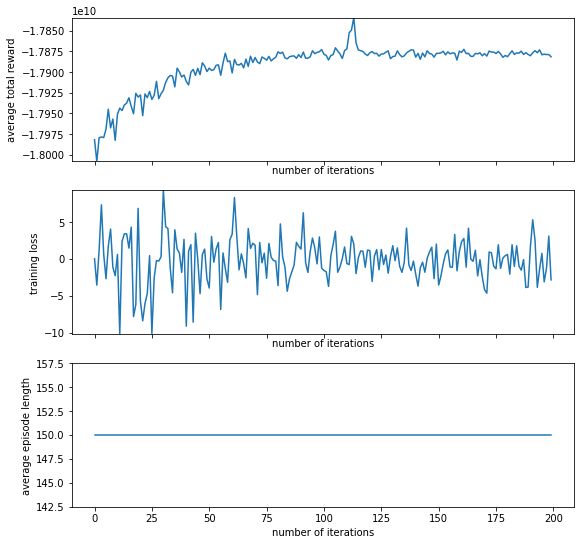

In [0]:
learned_policy = run_training_loop(env=env,n_iter=200,max_episode_length=150,batch_size=1000,learning_rate=1e-3,gamma=0.95)